# $D_{s1}(2460)^+\to D_s^+\gamma$ production study
## Yields
### Data analysis
#### Multiplicity proxies checks

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



In [1]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd 
from particle import Particle
import matplotlib.pyplot as plt
import os
import mplhep
ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
import RooPyFit as rpf
import RooPyShort as rsh

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()

%jsroot on

Welcome to JupyROOT 6.28/04
2024-04-09 16:19:13.831740
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
if not os.path.exists("./Graphs"):
    os.makedirs("./Graphs")
else:
    print("Graphs directory already exists")

if not os.path.exists("./root_files"):
    os.makedirs("./root_files")
else:
    print("root_files directory already exists")

## RDataFrame definition

### Data

In [3]:
path = "/scratch42/ivan.cambon/DsJ_Spectroscopy/Data_reduced/Selected_mcand"

Polarity = ["MagDown", "MagUp"]
Year = "2018"
files = ["MagD18", "MagU18"]

dtt = "DecayTree"

nTuples_Dsg = set(["{0}/{1}/{2}/DsgL_Data_{3}_sel_mcand.root".format(path, Polarity[i], Year, files[i]) for i in range(len(Polarity))])

tdf_data = ROOT.RDataFrame(dtt, nTuples_Dsg)

### MonteCarlo

In [4]:
priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

MC_Ds1_sig_files = "Ds1DsGamma*.root"
MC_Dsst_sig_files = "DsstDsGamma*.root"
dtt = "DsGammaTuple"

tdf_Dsst = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"DsstDsGamma*.root")
tdf_Dsst = tdf_Dsst.Define("DsgM", "Dsg_M-Ds_M+1969")

tdf_Ds1 = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"Ds1DsGamma*.root")
tdf_Ds1 = tdf_Ds1.Define("DsgM", "Dsg_M-Ds_M+1969")

## TRUEIDs and MCMatching

In [5]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]

TRUEID_Dsst = TRUEID_dtt["DsstDsGamma"]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

tdf_Dsst_sig = tdf_Dsst.Filter(TRUEID_Dsst)
tdf_Ds1_sig = tdf_Ds1.Filter(TRUEID_Ds1)

### Pre-Selection

In [6]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

off_sel  = "gamma_PT > 1200 && gamma_CL > 0.7 && abs(Ds_M-1969) < 20"
nPVs_req = "nPVs == 1"


L0_cond    = "(Ds_L0HadronDecision_TOS == 1 | Dsg_L0Global_TIS == 1)"
HLT1_cond  = "(Ds_Hlt1TrackMVADecision_TOS == 1 | Ds_Hlt1TwoTrackMVADecision_TOS == 1)"
HLT2_cond  = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS == 1)"
trig_conds = "{0} && {1} && {2}".format(L0_cond, HLT1_cond, HLT2_cond) 

L0_cond_int    = "(Ds_L0HadronDecision_TOS_int == 1 | Dsg_L0Global_TIS_int == 1)"
HLT1_cond_int  = "(Ds_Hlt1TrackMVADecision_TOS_int == 1 | Ds_Hlt1TwoTrackMVADecision_TOS_int == 1)"
HLT2_cond_int  = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS_int == 1)"
trig_conds_int = "{0} && {1} && {2}".format(L0_cond_int, HLT1_cond_int, HLT2_cond_int) 

MC_sel = "{0} && {1} && {2}".format(off_sel, nPVs_req, trig_conds)
data_sel = "{0} && {1} && {2}".format(off_sel, nPVs_req, trig_conds_int)

Dsst_window = "DsgM > 2050 && DsgM < 2250"
Ds1_window = "DsgM > 2350 && DsgM < 2600"

In [7]:
tdf_Dsst_sig_sel = tdf_Dsst_sig.Filter("{0} && {1}".format(MC_sel, Dsst_window))
tdf_Ds1_sig_sel = tdf_Ds1_sig.Filter("{0} && {1}".format(MC_sel, Ds1_window))

tdf_data_sel = tdf_data.Filter(data_sel)

### Mass Regions

In [8]:
low_mass = "DsgM < 2230"
medium_mass = "DsgM >= 2250 && DsgM < 2350"
high_mass = "DsgM >= 2350 && DsgM < 2700"
ultra_high_mass = "DsgM > 2700"

mass_cuts = [low_mass, medium_mass, high_mass, ultra_high_mass]

tdf_data_sel_masses = [tdf_data_sel.Filter(cuts) for cuts in mass_cuts]

In [9]:
histo_mass_sel = tdf_data_sel.Histo1D(("","",100,2000,3200), "DsgM")

In [10]:
mass_cuts = [2230, 2350, 2700]
lines = [ROOT.TLine(cut, 0 , cut, 60000) for cut in mass_cuts]
mass_label = "#it{M(D_{s}^{+}#gamma)} [MeV/c^{2}]"
i = 0

c1 = ROOT.TCanvas()
rsh.TH1D_plot(histo_mass_sel, xlabel=mass_label, color=1)
for line in lines:
    i += 1
    line.SetLineColor(i+1)
    line.Draw("SAME")
c1.Draw()
c1.SaveAs("Graphs/Exp_MagD18_DsgL_Dsg_mass_regions.pdf")

Info in <TCanvas::Print>: pdf file Graphs/Exp_MagD18_DsgL_Dsg_mass_regions.pdf has been created


### nVeloTracks for each mass region

In [11]:
nVeloTracks_histo_sel = tdf_data_sel.Histo1D(("","",350,0,350), "nVeloTracks")

nVeloTracks_histo_sel_mass_regions = [tdf.Histo1D(("","",350,0,350), "nVeloTracks") for tdf in tdf_data_sel_masses] 

In [12]:
i = 0 

c1 = ROOT.TCanvas("", "", 800, 600)
lgd = ROOT.TLegend(0.57, 0.55, 0.88, 0.85)
rsh.TH1D_plot(nVeloTracks_histo_sel, xlabel="nVeloTracks")
for hist in nVeloTracks_histo_sel_mass_regions:
    i += 1
    rsh.TH1D_plot(hist, xlabel="nVeloTracks", color=i+1)
rsh.legend_plot(lgd,
                [nVeloTracks_histo_sel.GetPtr()]+[hist.GetPtr() for hist in nVeloTracks_histo_sel_mass_regions],
                ["Data Full mass", "Data low mass", "Data medium mass", "Data high mass", "Data ultra high mass"],
                ["l", "l", "l", "l", "l"])
c1.Draw()
c1.SaveAs("Graphs/Exp_MagD18_DsgL_nVeloTracks_mass_regions.pdf")

Info in <TCanvas::Print>: pdf file Graphs/Exp_MagD18_DsgL_nVeloTracks_mass_regions.pdf has been created


In [13]:
nVeloTracks_histo_sel_Ds1 = tdf_Ds1_sig_sel.Histo1D(("","",350,0,350), "nVeloTracks")
nVeloTracks_histo_sel_Dsst = tdf_Dsst_sig_sel.Histo1D(("","",350,0,350), "nVeloTracks")

In [14]:
c1 = ROOT.TCanvas("", "", 1200, 1000)
c1.Divide(2, 1)
c1.cd(1)
lgd1 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
lgd2 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
rsh.TH1D_plot(nVeloTracks_histo_sel_Dsst, color=2, norm=True, linestyle=9, xlabel="nVeloTracks")
rsh.TH1D_plot(nVeloTracks_histo_sel_mass_regions[0], color=2, norm=True, opt="E SAME", xlabel="nVeloTracks")
rsh.legend_plot(lgd1, [nVeloTracks_histo_sel_Dsst.GetPtr(), nVeloTracks_histo_sel_mass_regions[0].GetPtr()],
                ["Dsst MC", "Data low mass"], ["l", "p"])
c1.cd(2)
rsh.TH1D_plot(nVeloTracks_histo_sel_Ds1, color=4, norm=True, linestyle=9, xlabel="nVeloTracks")
rsh.TH1D_plot(nVeloTracks_histo_sel_mass_regions[2], color=4, norm=True, opt="E SAME", xlabel="nVeloTracks")
rsh.legend_plot(lgd2, [nVeloTracks_histo_sel_Ds1.GetPtr(), nVeloTracks_histo_sel_mass_regions[2].GetPtr()],
                ["Ds1 MC", "Data high mass"], ["l", "p"])
c1.Draw()
c1.SaveAs("Graphs/Comp_DsgL_nVeloTracks_signal_mass_regions_1.pdf")

c2 = ROOT.TCanvas("", "", 1200, 1000)
c2.Divide(2, 1)
c2.cd(1)
lgd3 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
lgd4 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
rsh.TH1D_plot(nVeloTracks_histo_sel_Dsst, color=2, norm=True, xlabel="nVeloTracks")
rsh.TH1D_plot(nVeloTracks_histo_sel_Ds1, color=4, norm=True, xlabel="nVeloTracks")
rsh.legend_plot(lgd3, [nVeloTracks_histo_sel_Dsst.GetPtr(), nVeloTracks_histo_sel_Ds1.GetPtr()],
                ["Dsst MC", "Ds1 MC"], ["l", "l"])
c2.cd(2)
rsh.TH1D_plot(nVeloTracks_histo_sel_mass_regions[0], color=2, norm=True, opt="E SAME", xlabel="nVeloTracks")
rsh.TH1D_plot(nVeloTracks_histo_sel_mass_regions[2], color=4, norm=True, opt="E SAME", xlabel="nVeloTracks")
rsh.legend_plot(lgd4, [nVeloTracks_histo_sel_mass_regions[0].GetPtr(), nVeloTracks_histo_sel_mass_regions[2].GetPtr()],
                ["Data low mass", "Data high mass"], ["p", "p"])
c2.Draw()
c2.SaveAs("Graphs/Comp_DsgL_nVeloTracks_signal_mass_regions_2.pdf")

Info in <TCanvas::Print>: pdf file Graphs/Comp_DsgL_nVeloTracks_signal_mass_regions_1.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Comp_DsgL_nVeloTracks_signal_mass_regions_2.pdf has been created


### $p_{\mathrm{T}}(D_s^+)$ and $\eta(D_s^+)$ for each mass region

In [15]:
Ds_pt_histo_sel = tdf_data_sel.Histo1D(("","",100,1000,30000), "Ds_PT")
Ds_pt_histo_sel_mass_regions = [tdf.Histo1D(("","",100,1000,30000), "Ds_PT") for tdf in tdf_data_sel_masses] 

Ds_eta_histo_sel = tdf_data_sel.Histo1D(("","",100,1.5,5), "Ds_ETA")
Ds_eta_histo_sel_mass_regions = [tdf.Histo1D(("","",100,1.5,5), "Ds_ETA") for tdf in tdf_data_sel_masses]

In [16]:
i = 0 

c1 = ROOT.TCanvas("", "", 800, 600)
lgd1 = ROOT.TLegend(0.57, 0.55, 0.88, 0.85)
rsh.TH1D_plot(Ds_pt_histo_sel, xlabel="Ds_PT [MeV/c]")
for hist in Ds_pt_histo_sel_mass_regions:
    i += 1
    rsh.TH1D_plot(hist, xlabel="Ds_PT [MeV/c]", color=i+1)
rsh.legend_plot(lgd1,
                [Ds_pt_histo_sel.GetPtr()]+[hist.GetPtr() for hist in Ds_pt_histo_sel_mass_regions],
                ["Data Full mass", "Data low mass", "Data medium mass", "Data high mass", "Data ultra high mass"],
                ["l", "l", "l", "l", "l"])
c1.Draw()
c1.SaveAs("Graphs/Exp_2018_DsgL_Ds_PT_mass_regions.pdf")

i = 0

c2 = ROOT.TCanvas("", "", 800, 600)
lgd2 = ROOT.TLegend(0.60, 0.61, 0.92, 0.91)
rsh.TH1D_plot(Ds_eta_histo_sel, xlabel="Ds_ETA")
for hist in Ds_eta_histo_sel_mass_regions:
    i += 1
    rsh.TH1D_plot(hist, xlabel="Ds_ETA", color=i+1)
rsh.legend_plot(lgd2,
                [Ds_eta_histo_sel.GetPtr()]+[hist.GetPtr() for hist in Ds_eta_histo_sel_mass_regions],
                ["Data Full mass", "Data low mass", "Data medium mass", "Data high mass", "Data ultra high mass"],
                ["l", "l", "l", "l", "l"])
c2.Draw()
c2.SaveAs("Graphs/Exp_2018_DsgL_Ds_ETA_mass_regions.pdf")

Info in <TCanvas::Print>: pdf file Graphs/Exp_2018_DsgL_Ds_PT_mass_regions.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Exp_2018_DsgL_Ds_ETA_mass_regions.pdf has been created


In [17]:
Ds_pt_histo_sel_Ds1 = tdf_Ds1_sig_sel.Histo1D(("","",100,1000,30000), "Ds_PT")
Ds_pt_histo_sel_Dsst = tdf_Dsst_sig_sel.Histo1D(("","",100,1000,30000), "Ds_PT")

In [18]:
c1 = ROOT.TCanvas("", "", 1200, 1000)
c1.Divide(2, 1)
c1.cd(1)
lgd1 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
lgd2 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
rsh.TH1D_plot(Ds_pt_histo_sel_Dsst, color=2, norm=True, linestyle=9, xlabel="Ds_PT [MeV/c]")
rsh.TH1D_plot(Ds_pt_histo_sel_mass_regions[0], color=2, norm=True, opt="E SAME", xlabel="Ds_PT [MeV/c]")
rsh.legend_plot(lgd1, [Ds_pt_histo_sel_Dsst.GetPtr(), Ds_pt_histo_sel_mass_regions[0].GetPtr()],
                ["Dsst MC", "Data low mass"], ["l", "p"])
c1.cd(2)
rsh.TH1D_plot(Ds_pt_histo_sel_Ds1, color=4, norm=True, linestyle=9, xlabel="Ds_PT [MeV/c]")
rsh.TH1D_plot(Ds_pt_histo_sel_mass_regions[2], color=4, norm=True, opt="E SAME", xlabel="Ds_PT [MeV/c]")
rsh.legend_plot(lgd2, [Ds_pt_histo_sel_Ds1.GetPtr(), Ds_pt_histo_sel_mass_regions[2].GetPtr()],
                ["Ds1 MC", "Data high mass"], ["l", "p"])
c1.Draw()
c1.SaveAs("Graphs/Comp_DsgL_Ds_PT_signal_mass_regions_1.pdf")

c2 = ROOT.TCanvas("", "", 1200, 1000)
c2.Divide(2, 1)
c2.cd(1)
lgd3 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
lgd4 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
rsh.TH1D_plot(Ds_pt_histo_sel_Dsst, color=2, norm=True, xlabel="Ds_PT [MeV/c]")
rsh.TH1D_plot(Ds_pt_histo_sel_Ds1, color=4, norm=True, xlabel="Ds_PT [MeV/c]")
rsh.legend_plot(lgd3, [Ds_pt_histo_sel_Dsst.GetPtr(), Ds_pt_histo_sel_Ds1.GetPtr()],
                ["Dsst MC", "Ds1 MC"], ["l", "l"])
c2.cd(2)
rsh.TH1D_plot(Ds_pt_histo_sel_mass_regions[2], color=4, norm=True, opt="E SAME", xlabel="Ds_PT [MeV/c]")
rsh.TH1D_plot(Ds_pt_histo_sel_mass_regions[0], color=2, norm=True, opt="E SAME", xlabel="Ds_PT [MeV/c]")
rsh.legend_plot(lgd4, [Ds_pt_histo_sel_mass_regions[0].GetPtr(), Ds_pt_histo_sel_mass_regions[2].GetPtr()],
                ["Data low mass", "Data high mass"], ["p", "p"])
c2.Draw()
c2.SaveAs("Graphs/Comp_DsgL_Ds_PT_signal_mass_regions_2.pdf")

Info in <TCanvas::Print>: pdf file Graphs/Comp_DsgL_Ds_PT_signal_mass_regions_1.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Comp_DsgL_Ds_PT_signal_mass_regions_2.pdf has been created


In [19]:
Ds_eta_histo_sel_Ds1 = tdf_Ds1_sig_sel.Histo1D(("","",100,1.5,5.0), "Ds_ETA")
Ds_eta_histo_sel_Dsst = tdf_Dsst_sig_sel.Histo1D(("","",100,1.5,5.0), "Ds_ETA")

In [20]:
c1 = ROOT.TCanvas("", "", 1200, 1000)
c1.Divide(2, 1)
c1.cd(1)
lgd1 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
lgd2 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
rsh.TH1D_plot(Ds_eta_histo_sel_Dsst, color=2, norm=True, linestyle=9, xlabel="Ds_ETA")
rsh.TH1D_plot(Ds_eta_histo_sel_mass_regions[0], color=2, norm=True, opt="E SAME", xlabel="Ds_ETA")
rsh.legend_plot(lgd1, [Ds_eta_histo_sel_Dsst.GetPtr(), Ds_eta_histo_sel_mass_regions[0].GetPtr()],
                ["Dsst MC", "Data low mass"], ["l", "p"])
c1.cd(2)
rsh.TH1D_plot(Ds_eta_histo_sel_Ds1, color=4, norm=True, linestyle=9, xlabel="Ds_ETA")
rsh.TH1D_plot(Ds_eta_histo_sel_mass_regions[2], color=4, norm=True, opt="E SAME", xlabel="Ds_ETA")
rsh.legend_plot(lgd2, [Ds_eta_histo_sel_Ds1.GetPtr(), Ds_eta_histo_sel_mass_regions[2].GetPtr()],
                ["Ds1 MC", "Data high mass"], ["l", "p"])
c1.Draw()
c1.SaveAs("Graphs/Comp_DsgL_Ds_ETA_signal_mass_regions_1.pdf")

c2 = ROOT.TCanvas("", "", 1200, 1000)
c2.Divide(2, 1)
c2.cd(1)
lgd3 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
lgd4 = ROOT.TLegend(0.45, 0.55, 0.89, 0.88)
rsh.TH1D_plot(Ds_eta_histo_sel_Dsst, color=2, norm=True, xlabel="Ds_ETA")
rsh.TH1D_plot(Ds_eta_histo_sel_Ds1, color=4, norm=True, xlabel="Ds_ETA")
rsh.legend_plot(lgd3, [Ds_eta_histo_sel_Dsst.GetPtr(), Ds_eta_histo_sel_Ds1.GetPtr()],
                ["Dsst MC", "Ds1 MC"], ["l", "l"])
c2.cd(2)
rsh.TH1D_plot(Ds_eta_histo_sel_mass_regions[2], color=4, norm=True, opt="E SAME", xlabel="Ds_ETA")
rsh.TH1D_plot(Ds_eta_histo_sel_mass_regions[0], color=2, norm=True, opt="E SAME", xlabel="Ds_ETA")
rsh.legend_plot(lgd4, [Ds_eta_histo_sel_mass_regions[0].GetPtr(), Ds_eta_histo_sel_mass_regions[2].GetPtr()],
                ["Data low mass", "Data high mass"], ["p", "p"])
c2.Draw()
c2.SaveAs("Graphs/Comp_DsgL_Ds_ETA_signal_mass_regions_2.pdf")

Info in <TCanvas::Print>: pdf file Graphs/Comp_DsgL_Ds_ETA_signal_mass_regions_1.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Comp_DsgL_Ds_ETA_signal_mass_regions_2.pdf has been created


## Reweighting

### Reweighting in ROOT

In [21]:
# Reweighting in ROOT
def compute_weigths(hist_or, hist_tar, xmin, xmax):
    I_or = hist_or.Integral(); I_tar = hist_tar.Integral()
    
    hist_or_copy = hist_or.Clone()
    hist_or_copy.Scale(1 / I_or)
    
    hist_tar_copy = hist_tar.Clone()
    hist_tar_copy.Scale(1 / I_tar)
    
    nbins = hist_tar.GetNbinsX()
    hist_weights = ROOT.TH1D("", "", nbins, xmin, xmax)

    for i in range(1, nbins+1):
        num = hist_tar_copy.GetBinContent(i)
        den = hist_or_copy.GetBinContent(i)
        
        if den != 0:
            hist_weights.SetBinContent(i, num/den)
        else:
            hist_weights.SetBinContent(i, 0.)
        
    return hist_weights

def apply_weights(hist_or, hist_tar, xmin, xmax):
    hist_weights = compute_weigths(hist_or, hist_tar, xmin, xmax)
    nbins = hist_tar.GetNbinsX()

    hist_or_reweight = ROOT.TH1D("", "", nbins, xmin, xmax)
    
    for i in range(1, nbins+1):
        wi = hist_weights.GetBinContent(i)
        xi = hist_or.GetBinContent(i)
        
        hist_or_reweight.SetBinContent(i, wi*xi)
        
    return hist_or_reweight

In [22]:
nVelo_weights_Ds1 = compute_weigths(nVeloTracks_histo_sel_Ds1, 
                                    nVeloTracks_histo_sel_mass_regions[3],
                                    0, 
                                    350)

nVelo_weights_Dsst = compute_weigths(nVeloTracks_histo_sel_Dsst, 
                                     nVeloTracks_histo_sel_mass_regions[3],
                                     0, 
                                     350)

nVeloTracks_histo_sel_Ds1_rw = apply_weights(nVeloTracks_histo_sel_Ds1, 
                                             nVeloTracks_histo_sel_mass_regions[3],
                                             0, 
                                             350)

nVeloTracks_histo_sel_Dsst_rw = apply_weights(nVeloTracks_histo_sel_Ds1, 
                                              nVeloTracks_histo_sel_mass_regions[3],
                                              0, 
                                              350)

c1 = ROOT.TCanvas()
lgd1 = ROOT.TLegend(0.6, 0.6, 0.8, 0.8)
rsh.TH1D_plot(nVelo_weights_Ds1, color=4, xlabel="nVeloTracks", ylabel="weights")
rsh.TH1D_plot(nVelo_weights_Dsst, color=2, xlabel="nVeloTracks", ylabel="weights")
rsh.legend_plot(lgd1, [nVelo_weights_Ds1, nVelo_weights_Dsst], 
                ["Ds1 MC", "Dsst MC"], ["l", "l"])
c1.Draw()
c1.SaveAs("Graphs/Exp_MagD18_DsgL_nVeloTracks_weights.pdf")

c2 = ROOT.TCanvas()
lgd2 = ROOT.TLegend(0.5, 0.45, 0.9, 0.9)
rsh.TH1D_plot(nVeloTracks_histo_sel_Ds1, color=4, xlabel="nVeloTracks", norm=True)
rsh.TH1D_plot(nVeloTracks_histo_sel_Ds1_rw, color=4, opt="E same", xlabel="nVeloTracks", norm=True)
rsh.TH1D_plot(nVeloTracks_histo_sel_Dsst, color=2, xlabel="nVeloTracks", norm=True)
rsh.TH1D_plot(nVeloTracks_histo_sel_Dsst_rw, color=2, opt="E same", xlabel="nVeloTracks", norm=True)
rsh.TH1D_plot(nVeloTracks_histo_sel_mass_regions[3], color=5, xlabel="nVeloTracks", norm=True)
rsh.legend_plot(lgd2, 
                [nVeloTracks_histo_sel_Ds1.GetPtr(), nVeloTracks_histo_sel_Ds1_rw, nVeloTracks_histo_sel_Dsst.GetPtr(),
                 nVeloTracks_histo_sel_Dsst_rw, nVeloTracks_histo_sel_mass_regions[3].GetPtr()],
                ["Ds1 MC", "Ds1 MC rw", "Dsst MC", "Dsst MC rw", "Ultra High mass data"], ["l","p","l","p","l"])
c2.Draw()
c2.SaveAs("Graphs/Comp_DsgL_nVeloTracks_mass_regions_reweighting.pdf")

Info in <TCanvas::Print>: pdf file Graphs/Exp_MagD18_DsgL_nVeloTracks_weights.pdf has been created
Info in <TCanvas::Print>: pdf file Graphs/Comp_DsgL_nVeloTracks_mass_regions_reweighting.pdf has been created


### Reweighting with Python

In [23]:
df_data_sel_masses = [rsh.rdf_to_pdf(tdf, columns=["nVeloTracks", "DsgM", "Dsg_PT", "Dsg_ETA"]) for tdf in tdf_data_sel_masses]
df_Ds1_sig_sel  = rsh.rdf_to_pdf(tdf_Ds1_sig_sel, columns=["nVeloTracks", "DsgM", "Dsg_PT", "Dsg_ETA"])
df_Dsst_sig_sel = rsh.rdf_to_pdf(tdf_Dsst_sig_sel, columns=["nVeloTracks", "DsgM", "Dsg_PT", "Dsg_ETA"])

Text(0, 0.5, 'A.U')

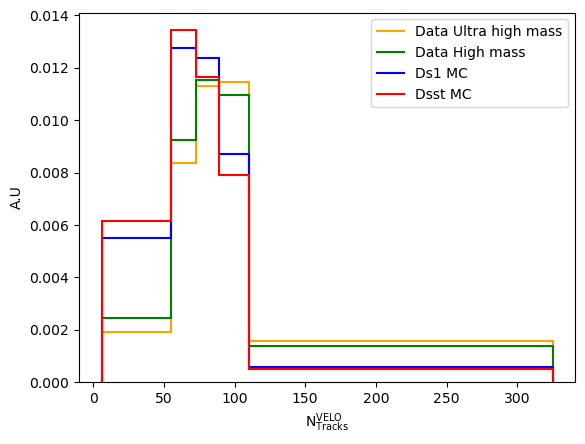

In [51]:
nVelo_bins = [6.00, 55.00, 73.00, 89.00, 110.00, 325.00]

histo_nVelo_Ds1_sig_sel, bins_nVelo_Ds1_sig_sel = np.histogram(df_Ds1_sig_sel["nVeloTracks"], bins=nVelo_bins)
histo_nVelo_Dsst_sig_sel, _ = np.histogram(df_Dsst_sig_sel["nVeloTracks"], bins=nVelo_bins)
histo_nVelo_data_uhm, _ = np.histogram((df_data_sel_masses[3])["nVeloTracks"], bins=nVelo_bins)
histo_nVelo_data_hm, _ = np.histogram((df_data_sel_masses[2])["nVeloTracks"], bins=nVelo_bins)

pdf_nVelo_Ds1_sig_sel, bins_nVelo_Ds1_sig_sel = np.histogram(df_Ds1_sig_sel["nVeloTracks"], bins=nVelo_bins, density=True)
pdf_nVelo_Dsst_sig_sel, _ = np.histogram(df_Dsst_sig_sel["nVeloTracks"], bins=nVelo_bins, density=True)
pdf_nVelo_data_uhm, _ = np.histogram((df_data_sel_masses[3])["nVeloTracks"], bins=nVelo_bins, density=True)
pdf_nVelo_data_hm, _ = np.histogram((df_data_sel_masses[2])["nVeloTracks"], bins=nVelo_bins, density=True)

plt.figure(1)
mplhep.histplot((pdf_nVelo_data_uhm, nVelo_bins), color="orange", label="Data Ultra high mass")
mplhep.histplot((pdf_nVelo_data_hm, nVelo_bins), color="green", label="Data High mass")
mplhep.histplot((pdf_nVelo_Ds1_sig_sel, nVelo_bins), color="blue", label="Ds1 MC")
mplhep.histplot((pdf_nVelo_Dsst_sig_sel, nVelo_bins), color="red", label="Dsst MC")
plt.legend()
plt.xlabel(r"$\mathrm{N_{Tracks}^{VELO}}$")
plt.ylabel("A.U")

Text(0, 0.5, 'A.U')

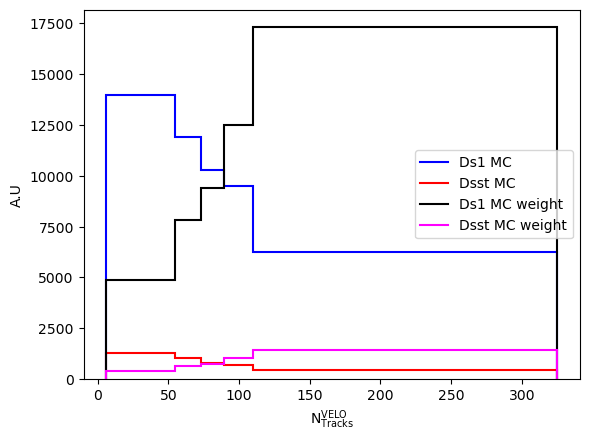

In [56]:
Ds1_weights  = pdf_nVelo_data_uhm / pdf_nVelo_Ds1_sig_sel
Dsst_weights = pdf_nVelo_data_uhm / pdf_nVelo_Dsst_sig_sel

histo_nVelo_Ds1_sig_sel_w = Ds1_weights * histo_nVelo_Ds1_sig_sel
histo_nVelo_Dsst_sig_sel_w = Dsst_weights * histo_nVelo_Dsst_sig_sel

plt.figure(1)
#mplhep.histplot((histo_nVelo_data_uhm, nVelo_bins), color="orange", label="Data Ultra high mass")
#mplhep.histplot((histo_nVelo_data_hm, nVelo_bins), color="green", label="Data High mass")
mplhep.histplot((histo_nVelo_Ds1_sig_sel, nVelo_bins), color="blue", label="Ds1 MC")
mplhep.histplot((histo_nVelo_Dsst_sig_sel, nVelo_bins), color="red", label="Dsst MC")
mplhep.histplot((histo_nVelo_Ds1_sig_sel_w, nVelo_bins), color="black", label="Ds1 MC weight")
mplhep.histplot((histo_nVelo_Dsst_sig_sel_w, nVelo_bins), color="magenta", label="Dsst MC weight")
plt.legend()
plt.xlabel(r"$\mathrm{N_{Tracks}^{VELO}}$")
plt.ylabel("A.U")